# U-Net Architecture

In [7]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# U-Net Architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Define encoder layers
        self.enc1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, padding_mode='reflect')
        self.enc2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, padding_mode='reflect')
        self.enc3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, padding_mode='reflect')
        self.enc4 = nn.Conv2d(256, 512, kernel_size=3, padding=1, padding_mode='reflect')
        
        # Define bottleneck layer
        self.bottleneck = nn.Conv2d(512, 1024, kernel_size=3, padding=1, padding_mode='reflect')
        
        # Define decoder layers with concatenation in mind
        self.dec4 = nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1, padding_mode='reflect')
        self.dec3 = nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1, padding_mode='reflect')
        self.dec2 = nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1, padding_mode='reflect')
        
        # Final output layer
        self.final = nn.Conv2d(128, 1, kernel_size=1)

    def forward(self, x):
        # Encoder with max-pooling
        x1 = F.relu(self.enc1(x))
        x2 = F.relu(self.enc2(F.max_pool2d(x1, 2)))
        x3 = F.relu(self.enc3(F.max_pool2d(x2, 2)))
        x4 = F.relu(self.enc4(F.max_pool2d(x3, 2)))
        
        # Bottleneck
        x = F.relu(self.bottleneck(F.max_pool2d(x4, 2)))
        
        # Decoder with upsampling and concatenation of encoder outputs
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x4], dim=1)  # Concatenate encoder output from enc4
        x = F.relu(self.dec4(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x3], dim=1)  # Concatenate encoder output from enc3
        x = F.relu(self.dec3(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x2], dim=1)  # Concatenate encoder output from enc2
        x = F.relu(self.dec2(x))
        
        # Final layer (no activation for regression tasks)
        return self.final(x)

In [359]:
# U-Net with 4 decoders
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Define encoder layers
        self.enc1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, padding_mode='reflect')
        self.enc2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, padding_mode='reflect')
        self.enc3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, padding_mode='reflect')
        self.enc4 = nn.Conv2d(256, 512, kernel_size=3, padding=1, padding_mode='reflect')
        
        # Define bottleneck layer
        self.bottleneck = nn.Conv2d(512, 1024, kernel_size=3, padding=1, padding_mode='reflect')
        
        # Define decoder layers
        self.dec4 = nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1, padding_mode='reflect')
        self.dec3 = nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1, padding_mode='reflect')
        self.dec2 = nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1, padding_mode='reflect')
        self.dec1 = nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1, padding_mode='reflect')
        
        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder with max-pooling
        x1 = F.relu(self.enc1(x))
        x2 = F.relu(self.enc2(F.max_pool2d(x1, 2)))
        x3 = F.relu(self.enc3(F.max_pool2d(x2, 2)))
        x4 = F.relu(self.enc4(F.max_pool2d(x3, 2)))
        
        # Bottleneck
        x = F.relu(self.bottleneck(F.max_pool2d(x4, 2)))
        
        # Decoder with upsampling and concatenation of encoder outputs
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x4], dim=1)
        x = F.relu(self.dec4(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x3], dim=1)
        x = F.relu(self.dec3(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x2], dim=1)
        x = F.relu(self.dec2(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x1], dim=1)
        x = F.relu(self.dec1(x))
        
        # Final layer
        return self.final(x)


# Training Model (do not run!)

Epoch [1/50]: 100%|██████████| 8/8 [10:41<00:00, 80.14s/batch, loss=0.107] 


Epoch [1/50], Loss: 0.39583578892052174
Validation Loss: 0.15177355706691742


Epoch [2/50]: 100%|██████████| 8/8 [10:40<00:00, 80.00s/batch, loss=0.0444]


Epoch [2/50], Loss: 0.07133509940467775
Validation Loss: 0.02712646871805191


Epoch [3/50]: 100%|██████████| 8/8 [10:39<00:00, 79.88s/batch, loss=0.0183]


Epoch [3/50], Loss: 0.028618236538022757
Validation Loss: 0.025898187421262264


Epoch [4/50]: 100%|██████████| 8/8 [10:37<00:00, 79.71s/batch, loss=0.0231]


Epoch [4/50], Loss: 0.02308425249066204
Validation Loss: 0.020662682130932808


Epoch [5/50]: 100%|██████████| 8/8 [10:39<00:00, 79.91s/batch, loss=0.0131]


Epoch [5/50], Loss: 0.014381667599081993
Validation Loss: 0.009135729167610407


Epoch [6/50]: 100%|██████████| 8/8 [10:38<00:00, 79.76s/batch, loss=0.00787]


Epoch [6/50], Loss: 0.008982988074421883
Validation Loss: 0.009317365474998951


Epoch [7/50]: 100%|██████████| 8/8 [10:41<00:00, 80.14s/batch, loss=0.00679]


Epoch [7/50], Loss: 0.0075659340946003795
Validation Loss: 0.006272252183407545


Epoch [8/50]: 100%|██████████| 8/8 [10:42<00:00, 80.37s/batch, loss=0.00664]


Epoch [8/50], Loss: 0.006309094955213368
Validation Loss: 0.006648873444646597


Epoch [9/50]: 100%|██████████| 8/8 [10:40<00:00, 80.04s/batch, loss=0.00626]


Epoch [9/50], Loss: 0.006059102539438754
Validation Loss: 0.006161230616271496


Epoch [10/50]: 100%|██████████| 8/8 [10:40<00:00, 80.00s/batch, loss=0.0059] 


Epoch [10/50], Loss: 0.005801341438200325
Validation Loss: 0.005832355469465256


Epoch [11/50]: 100%|██████████| 8/8 [10:37<00:00, 79.73s/batch, loss=0.00495]


Epoch [11/50], Loss: 0.005504494241904467
Validation Loss: 0.005683836759999394


Epoch [12/50]: 100%|██████████| 8/8 [10:39<00:00, 79.99s/batch, loss=0.00565]


Epoch [12/50], Loss: 0.005449873744510114
Validation Loss: 0.005573437782004476


Epoch [13/50]: 100%|██████████| 8/8 [10:38<00:00, 79.85s/batch, loss=0.00525]


Epoch [13/50], Loss: 0.00530407449696213
Validation Loss: 0.0054412828758358955


Epoch [14/50]: 100%|██████████| 8/8 [10:39<00:00, 79.91s/batch, loss=0.00521]


Epoch [14/50], Loss: 0.005233455973211676
Validation Loss: 0.005448505748063326


Epoch [15/50]: 100%|██████████| 8/8 [10:40<00:00, 80.08s/batch, loss=0.00545]


Epoch [15/50], Loss: 0.005260220263153315
Validation Loss: 0.00533489091321826


Epoch [16/50]: 100%|██████████| 8/8 [10:40<00:00, 80.04s/batch, loss=0.00598]


Epoch [16/50], Loss: 0.005257792072370648
Validation Loss: 0.00531537109054625


Epoch [17/50]: 100%|██████████| 8/8 [10:39<00:00, 79.90s/batch, loss=0.00565]


Epoch [17/50], Loss: 0.005206030793488026
Validation Loss: 0.005306648556143045


Epoch [18/50]: 100%|██████████| 8/8 [10:41<00:00, 80.14s/batch, loss=0.0051] 


Epoch [18/50], Loss: 0.005152813682798296
Validation Loss: 0.005292764166370034


Epoch [19/50]: 100%|██████████| 8/8 [10:43<00:00, 80.49s/batch, loss=0.00464]


Epoch [19/50], Loss: 0.005076118570286781
Validation Loss: 0.005280534271150827


Epoch [20/50]: 100%|██████████| 8/8 [10:43<00:00, 80.48s/batch, loss=0.00569]


Epoch [20/50], Loss: 0.005180483858566731
Validation Loss: 0.005258840741589665


Epoch [21/50]: 100%|██████████| 8/8 [10:45<00:00, 80.70s/batch, loss=0.00518]


Epoch [21/50], Loss: 0.005099636036902666
Validation Loss: 0.005319987889379263


Epoch [22/50]: 100%|██████████| 8/8 [10:41<00:00, 80.25s/batch, loss=0.00527]


Epoch [22/50], Loss: 0.0051154434913769364
Validation Loss: 0.0052400457207113504


Epoch [23/50]: 100%|██████████| 8/8 [10:46<00:00, 80.79s/batch, loss=0.00584]


Epoch [23/50], Loss: 0.005162834015209228
Validation Loss: 0.005234448937699199


Epoch [24/50]: 100%|██████████| 8/8 [10:46<00:00, 80.86s/batch, loss=0.00459]


Epoch [24/50], Loss: 0.005005801562219858
Validation Loss: 0.005217959638684988


Epoch [25/50]: 100%|██████████| 8/8 [10:47<00:00, 80.90s/batch, loss=0.00507]


Epoch [25/50], Loss: 0.005053347325883806
Validation Loss: 0.005260870326310396


Epoch [26/50]: 100%|██████████| 8/8 [10:43<00:00, 80.45s/batch, loss=0.00445]


Epoch [26/50], Loss: 0.004997402895241976
Validation Loss: 0.0052108431700617075


Epoch [27/50]: 100%|██████████| 8/8 [10:49<00:00, 81.17s/batch, loss=0.005]  


Epoch [27/50], Loss: 0.0050328005454503
Validation Loss: 0.005251075839623809


Epoch [28/50]: 100%|██████████| 8/8 [10:48<00:00, 81.03s/batch, loss=0.00514]


Epoch [28/50], Loss: 0.0050549249281175435
Validation Loss: 0.005178661551326513


Epoch [29/50]: 100%|██████████| 8/8 [10:48<00:00, 81.04s/batch, loss=0.00449]


Epoch [29/50], Loss: 0.004958839854225516
Validation Loss: 0.0051702409982681274


Epoch [30/50]: 100%|██████████| 8/8 [10:49<00:00, 81.15s/batch, loss=0.0049] 


Epoch [30/50], Loss: 0.005001039942726493
Validation Loss: 0.005165071925148368


Epoch [31/50]: 100%|██████████| 8/8 [10:46<00:00, 80.86s/batch, loss=0.00527]


Epoch [31/50], Loss: 0.005033979250583798
Validation Loss: 0.005215914221480489


Epoch [32/50]: 100%|██████████| 8/8 [10:48<00:00, 81.11s/batch, loss=0.00496]


Epoch [32/50], Loss: 0.00500657910015434
Validation Loss: 0.005158179672434926


Epoch [33/50]: 100%|██████████| 8/8 [10:48<00:00, 81.01s/batch, loss=0.0053] 


Epoch [33/50], Loss: 0.005026653234381229
Validation Loss: 0.005137106869369745


Epoch [34/50]: 100%|██████████| 8/8 [10:48<00:00, 81.12s/batch, loss=0.00474]


Epoch [34/50], Loss: 0.004953711002599448
Validation Loss: 0.005259001161903143


Epoch [35/50]: 100%|██████████| 8/8 [10:47<00:00, 80.97s/batch, loss=0.00567]


Epoch [35/50], Loss: 0.00509655853966251
Validation Loss: 0.005167906871065497


Epoch [36/50]: 100%|██████████| 8/8 [10:47<00:00, 80.93s/batch, loss=0.00528]


Epoch [36/50], Loss: 0.005006783292628825
Validation Loss: 0.005151913966983557


Epoch [37/50]: 100%|██████████| 8/8 [10:46<00:00, 80.78s/batch, loss=0.00475]


Epoch [37/50], Loss: 0.004941932624205947
Validation Loss: 0.005157712148502469


Epoch [38/50]: 100%|██████████| 8/8 [10:47<00:00, 80.93s/batch, loss=0.00433]


Epoch [38/50], Loss: 0.0048914939397946
Validation Loss: 0.005200128769502044


Epoch [39/50]: 100%|██████████| 8/8 [10:52<00:00, 81.59s/batch, loss=0.0045] 


Epoch [39/50], Loss: 0.004921920946799219
Validation Loss: 0.005085453623905778


Epoch [40/50]: 100%|██████████| 8/8 [10:50<00:00, 81.27s/batch, loss=0.00465]


Epoch [40/50], Loss: 0.004919509112369269
Validation Loss: 0.005081395618617535


Epoch [41/50]: 100%|██████████| 8/8 [10:49<00:00, 81.14s/batch, loss=0.00487]


Epoch [41/50], Loss: 0.004934423661325127
Validation Loss: 0.005088816862553358


Epoch [42/50]: 100%|██████████| 8/8 [10:48<00:00, 81.04s/batch, loss=0.0045] 


Epoch [42/50], Loss: 0.0049001387087628245
Validation Loss: 0.005164602538570762


Epoch [43/50]: 100%|██████████| 8/8 [10:48<00:00, 81.03s/batch, loss=0.00556]


Epoch [43/50], Loss: 0.0050044910167343915
Validation Loss: 0.0050703962333500385


Epoch [44/50]: 100%|██████████| 8/8 [10:49<00:00, 81.22s/batch, loss=0.00491]


Epoch [44/50], Loss: 0.00491277250694111
Validation Loss: 0.005066222278401256


Epoch [45/50]: 100%|██████████| 8/8 [10:48<00:00, 81.03s/batch, loss=0.00575]


Epoch [45/50], Loss: 0.0050284735625609756
Validation Loss: 0.005313755013048649


Epoch [46/50]: 100%|██████████| 8/8 [10:49<00:00, 81.13s/batch, loss=0.00559]


Epoch [46/50], Loss: 0.005068302736617625
Validation Loss: 0.005101862596347928


Epoch [47/50]: 100%|██████████| 8/8 [10:47<00:00, 80.99s/batch, loss=0.00461]


Epoch [47/50], Loss: 0.004917178652249277
Validation Loss: 0.005073306150734425


Epoch [48/50]: 100%|██████████| 8/8 [10:48<00:00, 81.07s/batch, loss=0.00467]


Epoch [48/50], Loss: 0.004895842343103141
Validation Loss: 0.005064903758466244


Epoch [49/50]: 100%|██████████| 8/8 [10:48<00:00, 81.11s/batch, loss=0.00473]


Epoch [49/50], Loss: 0.0048864775453694165
Validation Loss: 0.005039907293394208


Epoch [50/50]: 100%|██████████| 8/8 [10:49<00:00, 81.14s/batch, loss=0.0059] 


Epoch [50/50], Loss: 0.004996436065994203
Validation Loss: 0.0050591412000358105


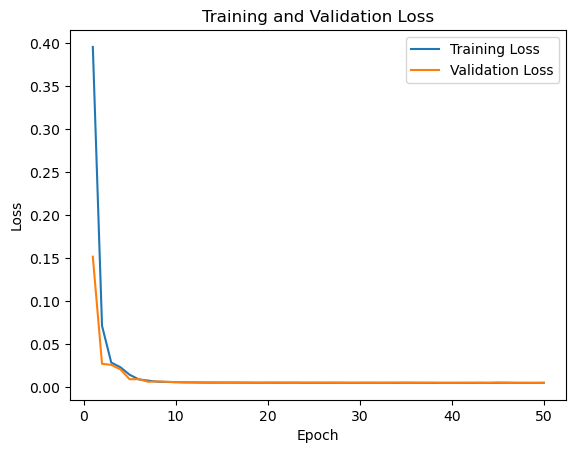

In [14]:
# Helper function to find image file by ID
def find_image_path(directory, prefix, image_id):
    path = os.path.join(directory, f"{prefix}_id{image_id}.png")
    return path if os.path.exists(path) else None

# Function to create a binary mask for non-gray pixels
def building_mask(image_path, gray_threshold=10):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    r, g, b = image_np[:, :, 0], image_np[:, :, 1], image_np[:, :, 2]
    max_diff = np.abs(r - g) + np.abs(r - b) + np.abs(g - b)
    return (max_diff > gray_threshold).astype(np.float32)

# Unified Dataset class
class SatelliteHeatmapDataset(Dataset):
    def __init__(self, satellite_dir, heatmap_dir, transform=None, ids=None):
        self.satellite_dir = satellite_dir
        self.heatmap_dir = heatmap_dir
        self.transform = transform

        # Use provided IDs or extract from directory
        if ids is not None:
            self.satellite_ids = ids
        else:
            self.satellite_ids = [os.path.splitext(f)[0].split('_id')[-1]
                                  for f in os.listdir(satellite_dir) if os.path.isfile(os.path.join(satellite_dir, f))]

    def __len__(self):
        return len(self.satellite_ids)

    def __getitem__(self, idx):
        image_id = self.satellite_ids[idx]
        satellite_path = find_image_path(self.satellite_dir, "satellite", image_id)
        heatmap_path = find_image_path(self.heatmap_dir, "heatmap", image_id)

        if satellite_path is None or heatmap_path is None:
            return None  # Ignore missing files silently

        satellite_image = Image.open(satellite_path).convert("RGB")
        heatmap_image = Image.open(heatmap_path).convert("L")
        mask = building_mask(heatmap_path)

        if self.transform:
            satellite_image = self.transform(satellite_image)
            heatmap_image = self.transform(heatmap_image)
            mask = torch.tensor(mask).unsqueeze(0)  # Add channel dimension

        return satellite_image, heatmap_image, mask

# Custom collate function
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0), torch.empty(0)
    return torch.utils.data.default_collate(batch)

# Directories
satellite_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Satellite'
heatmap_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Heatmap'

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Full dataset
dataset = SatelliteHeatmapDataset(satellite_dir, heatmap_dir, transform=transform)

# Split IDs
train_ids, val_ids = train_test_split(dataset.satellite_ids, test_size=0.2, random_state=42)

# Training and validation datasets
train_dataset = SatelliteHeatmapDataset(satellite_dir, heatmap_dir, transform=transform, ids=train_ids)
val_dataset = SatelliteHeatmapDataset(satellite_dir, heatmap_dir, transform=transform, ids=val_ids)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)

# Model
model = UNet()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train_model(model, train_loader, val_loader, num_epochs):
    train_losses = []
    val_losses = []

    try:
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
                for satellite_images, heatmap_images, masks in train_loader:
                    optimizer.zero_grad()
                    outputs = model(satellite_images)
                    outputs_resized = F.interpolate(outputs, size=heatmap_images.shape[2:], mode='bilinear', align_corners=True)
                    # Calculate masked loss
                    masked_loss = (((outputs_resized - heatmap_images) ** 2) * masks).mean()
                    masked_loss.backward()
                    optimizer.step()
                    running_loss += masked_loss.item()
                    pbar.update(1)
                    pbar.set_postfix(loss=masked_loss.item())

            train_losses.append(running_loss / len(train_loader))
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

            val_loss = evaluate_model(model, val_loader)
            val_losses.append(val_loss)
            print(f"Validation Loss: {val_loss}")

    except KeyboardInterrupt:
        print("Training interrupted! Plotting progress...")
    
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Validation function
def evaluate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for satellite_images, heatmap_images, masks in val_loader:
            outputs = model(satellite_images)
            outputs_resized = F.interpolate(outputs, size=heatmap_images.shape[2:], mode='bilinear', align_corners=True)
            masked_loss = (((outputs_resized - heatmap_images) ** 2) * masks).mean()
            val_loss += masked_loss.item()
    return val_loss / len(val_loader)

# Train and save the model
train_model(model, train_loader, val_loader, num_epochs=50)
torch.save(model.state_dict(), "/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/03TrainedModel/satellite_to_heatmap_unet_mask.pth")


# Prediction

/var/folders/23/bgygmh4x281cznmrp1yt_r1h0000gn/T/ipykernel_95699/3965065865.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/jann

Predicted heatmap saved to /Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Prediction_Large/prediction_id101.png


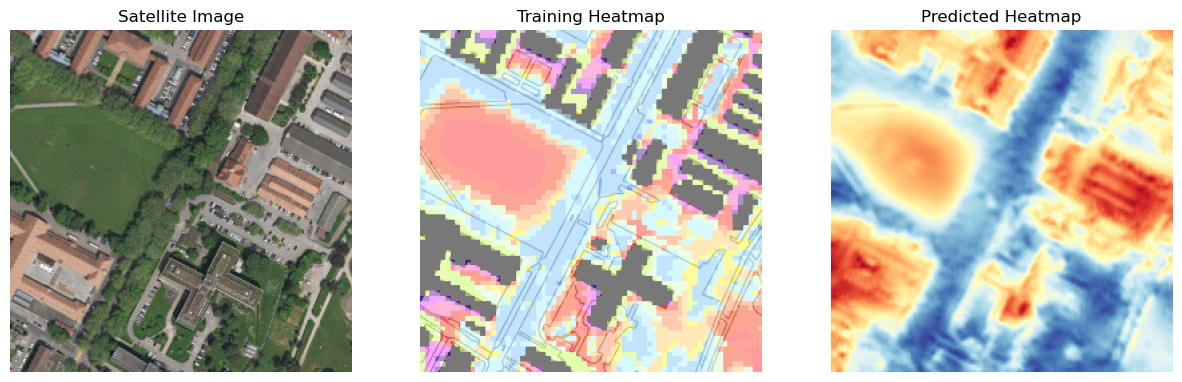

In [392]:
# Masked Prediction Control
model = UNet()
model.load_state_dict(torch.load("/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/03TrainedModel/satellite_to_heatmap_unet_mask.pth"))
model.eval()  # Set model to evaluation mode

# Directories
output_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Prediction_Large'
satellite_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Satellite_Large'
heatmap_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Heatmap_Large'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Function to predict and display heatmap for a specific satellite image
def predict_and_display_heatmap(model, satellite_dir, heatmap_dir, output_dir, transform, image_id):
    # Construct the satellite image file name based on the given ID
    satellite_file = f"satellite_id{image_id}.png"
    
    # Verify the satellite file exists
    satellite_image_path = os.path.join(satellite_dir, satellite_file)
    if not os.path.exists(satellite_image_path):
        raise FileNotFoundError(f"Satellite image not found: {satellite_image_path}")
    
    # Load and transform the satellite image
    satellite_image = Image.open(satellite_image_path).convert("RGB")
    satellite_tensor = transform(satellite_image).unsqueeze(0)  # Add batch dimension

    # Load the corresponding training heatmap
    heatmap_file = satellite_file.replace("satellite", "heatmap")
    heatmap_image_path = os.path.join(heatmap_dir, heatmap_file)
    heatmap_image = Image.open(heatmap_image_path).convert("RGB")

    # Predict the heatmap
    with torch.no_grad():
        predicted_heatmap = model(satellite_tensor)

    # Resize predicted heatmap to match the input image dimensions
    predicted_heatmap_resized = F.interpolate(predicted_heatmap, size=satellite_image.size[::-1], mode='bilinear', align_corners=True)

    # Remove batch dimension and convert to numpy
    predicted_heatmap_resized = predicted_heatmap_resized.squeeze(0).squeeze(0).cpu().numpy()

    # Save the predicted heatmap
    output_file = satellite_file.replace("satellite", "prediction")
    output_path = os.path.join(output_dir, output_file)
    save_image(torch.tensor(predicted_heatmap_resized).unsqueeze(0), output_path)
    print(f"Predicted heatmap saved to {output_path}")

    # Display the satellite image, training heatmap, and predicted heatmap
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(satellite_image)
    plt.title("Satellite Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_image)
    plt.title("Training Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_heatmap_resized, cmap='RdYlBu')
    plt.title("Predicted Heatmap")
    plt.axis("off")

    plt.show()

# Example usage
image_id = "101"  # Specify the ID of the satellite image
predict_and_display_heatmap(model, satellite_dir, heatmap_dir, output_dir, transform, image_id)


/var/folders/23/bgygmh4x281cznmrp1yt_r1h0000gn/T/ipykernel_95699/3014487578.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/jann

/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Satellite/satellite_id2220.png
Predicted heatmap saved to /Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Prediction/prediction_id2220.png


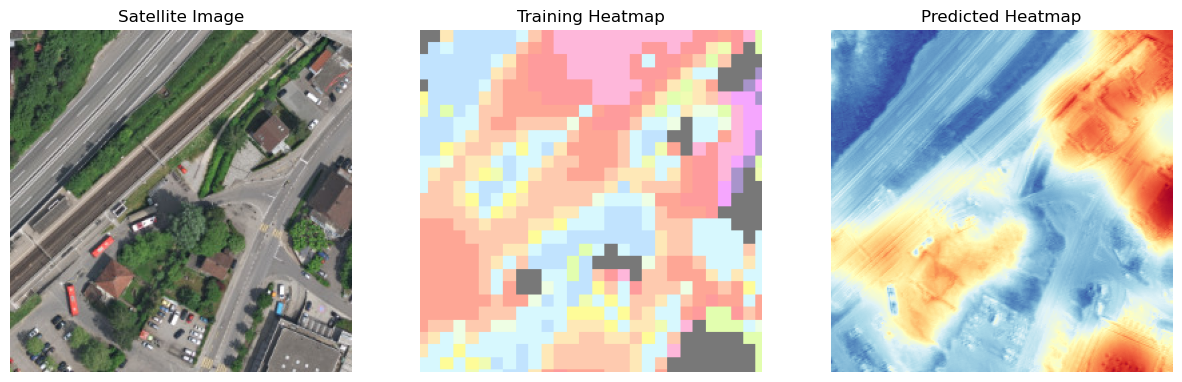

In [371]:
# Unmasked Prediction Control
model = UNet()
model.load_state_dict(torch.load("/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/03TrainedModel/satellite_to_heatmap_unet.pth"))
model.eval()  # Set model to evaluation mode

# Directories
output_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Prediction'
satellite_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Satellite'
heatmap_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Heatmap'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Function to predict and display heatmap for a random satellite image
def predict_and_display_heatmap(model, satellite_dir, heatmap_dir, output_dir, transform):
    satellite_files = os.listdir(satellite_dir)
    random_file = random.choice(satellite_files)
    
    # Load and transform the satellite image
    satellite_image_path = os.path.join(satellite_dir, random_file)
    satellite_image = Image.open(satellite_image_path)
    satellite_tensor = transform(satellite_image).unsqueeze(0)  # Add batch dimension
    print(satellite_image_path)
    # Load the corresponding training heatmap
    heatmap_image_path = os.path.join(heatmap_dir, random_file.replace("satellite", "heatmap"))
    heatmap_image = Image.open(heatmap_image_path)

    # Predict the heatmap
    with torch.no_grad():
        predicted_heatmap = model(satellite_tensor)

    # Remove batch dimension and convert to numpy
    predicted_heatmap = predicted_heatmap.squeeze(0).squeeze(0).cpu().numpy()

    # Save the predicted heatmap
    output_file = random_file.replace("satellite", "prediction")
    output_path = os.path.join(output_dir, output_file)
    save_image(torch.tensor(predicted_heatmap).unsqueeze(0), output_path)
    print(f"Predicted heatmap saved to {output_path}")

    # Display the satellite image, training heatmap, and predicted heatmap
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(satellite_image)
    plt.title("Satellite Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_image)
    plt.title("Training Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_heatmap, cmap='RdYlBu_r')
    plt.title("Predicted Heatmap")
    plt.axis("off")

    plt.show()

# Run the prediction and display
predict_and_display_heatmap(model, satellite_dir, heatmap_dir, output_dir, transform)

/var/folders/23/bgygmh4x281cznmrp1yt_r1h0000gn/T/ipykernel_56173/2946538196.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/jann

Predicted heatmap saved to /Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/04_ResizeImage/Luzern_Heatmap.png


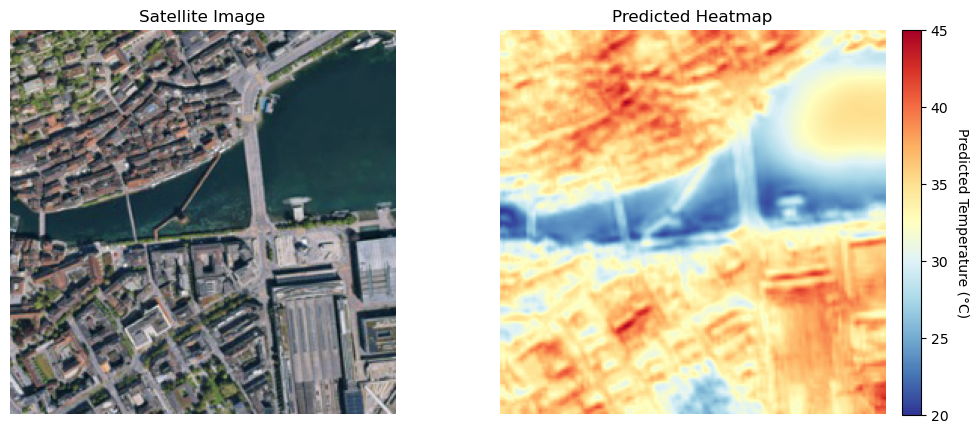

In [13]:
# Load the trained model
model = UNet()
model.load_state_dict(torch.load("/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/03TrainedModel/satellite_to_heatmap_unet_mask.pth"))
model.eval()  # Set model to evaluation mode

# Define transformations (same as training)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Function to predict and save heatmap for a specific satellite image
def predict_for_image(model, input_image_path, output_image_path):
    # Verify input image exists
    if not os.path.exists(input_image_path):
        raise FileNotFoundError(f"Input image not found: {input_image_path}")
    
    # Check if file format is supported
    if not input_image_path.lower().endswith((".png", ".jpg", ".jpeg")):
        raise ValueError(f"Unsupported file format. Use PNG, JPG, or JPEG: {input_image_path}")

    # Load and transform the satellite image
    satellite_image = Image.open(input_image_path).convert("RGB")  # Ensure RGB format
    satellite_tensor = transform(satellite_image).unsqueeze(0)  # Add batch dimension

    # Predict the heatmap
    with torch.no_grad():
        predicted_heatmap = model(satellite_tensor)

    # Resize the predicted heatmap to match the input image dimensions (256x256)
    predicted_heatmap_resized = F.interpolate(predicted_heatmap, size=satellite_image.size, mode='bilinear', align_corners=True)

    # Remove batch dimension and convert to numpy
    predicted_heatmap_resized = predicted_heatmap_resized.squeeze(0).squeeze(0).cpu().numpy()

    # Print the min and max predicted values
    min_val = predicted_heatmap_resized.min()
    max_val = predicted_heatmap_resized.max()

    # Map the predicted heatmap values to the temperature range 25°C to 45°C
    temp_min, temp_max = 20, 45
    mapped_heatmap = (predicted_heatmap_resized - min_val) / (max_val - min_val) * (temp_min - temp_max) + temp_max

    # Save the predicted heatmap
    save_image(torch.tensor(mapped_heatmap).unsqueeze(0), output_image_path)
    print(f"Predicted heatmap saved to {output_image_path}")

    # Display the satellite image and predicted heatmap with remapped colorbar
    plt.figure(figsize=(12, 5))
    
    # Plot satellite image
    plt.subplot(1, 2, 1)
    plt.imshow(satellite_image)
    plt.title("Satellite Image")
    plt.axis("off")

    # Plot predicted heatmap
    plt.subplot(1, 2, 2)
    heatmap_plot = plt.imshow(mapped_heatmap, cmap='RdYlBu_r', vmin=temp_min, vmax=temp_max)
    plt.title("Predicted Heatmap")
    plt.axis("off")

    # Add a colorbar with remapped range (25 to 45)
    cbar = plt.colorbar(heatmap_plot, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label("Predicted Temperature (°C)", rotation=270, labelpad=15)
    
    plt.show()

# Example usage
input_image_path = "//Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/04_ResizeImage/Luzern.png"  # Change this to the path of your input image
output_image_path = "/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/04_ResizeImage/Luzern_Heatmap.png"  # Change this to the desired output path

predict_for_image(model, input_image_path, output_image_path)
